In [382]:
import tensorflow as tf
import os

In [383]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [384]:
tf.config.list_physical_devices('GPU')

[]

Sort Out Images

In [385]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [386]:
data_dir = 'data'

In [387]:
os.listdir(data_dir)

['happy', 'sad']

In [388]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [389]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(iamge_path))
            # os.remove(image_path)

Load Data

In [390]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [391]:
import numpy as np
from matplotlib import pyplot as plt

In [392]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 179 files belonging to 2 classes.


In [393]:
data_iterator = data.as_numpy_iterator()

In [394]:
# Get another batch from the iterator
batch = data_iterator.next()

In [395]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [396]:
# Class 1 = sad, Class 0 = happy
batch[1]

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0])

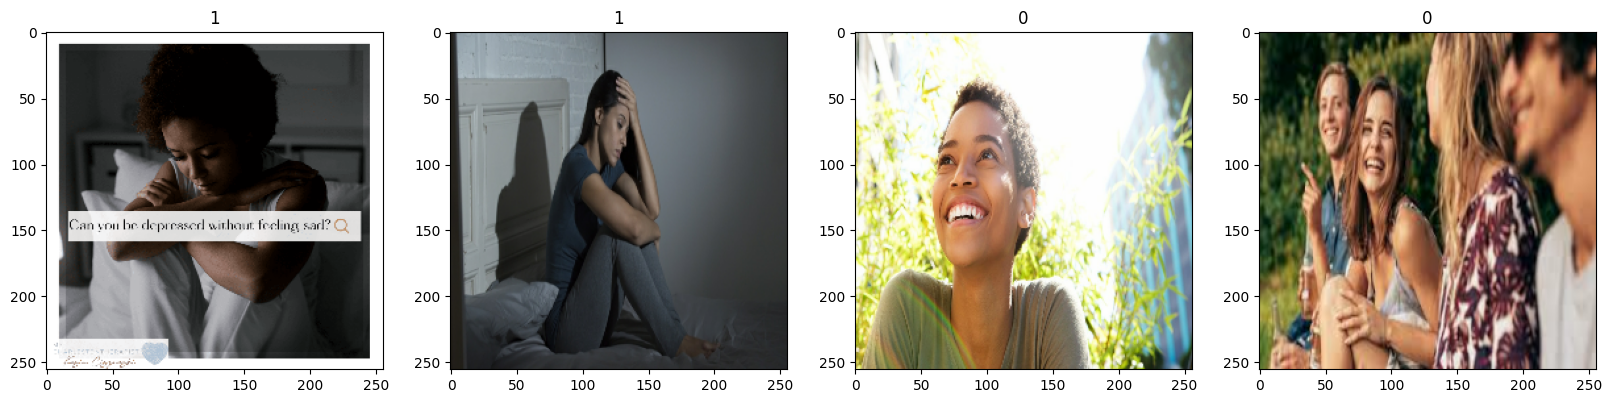

In [397]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocess Data

Scale Data

In [398]:
data = data.map(lambda x,y: (x/255, y))

In [399]:
scaled_iterator = data.as_numpy_iterator()

In [400]:
batch = scaled_iterator.next()

In [401]:
batch[0].max()

1.0

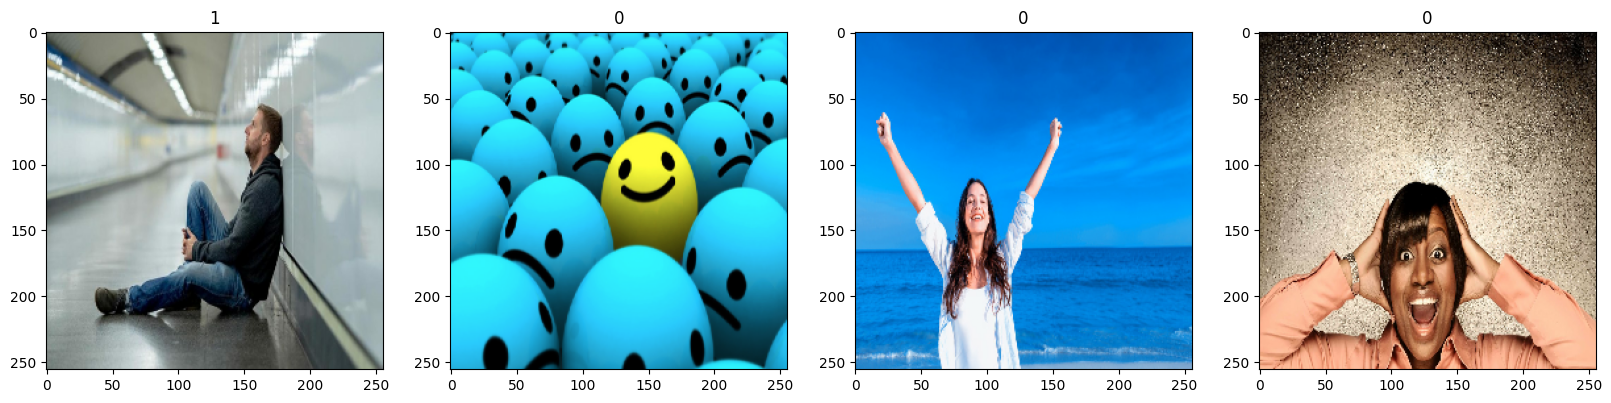

In [402]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Split data

In [403]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [404]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Build Deep Learning Model

In [405]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [406]:
model = Sequential()

In [407]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [408]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [409]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 16)       

Train

In [410]:
logdir = 'logs'

In [411]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [412]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 4s 700ms/step - loss: 1.9352 - accuracy: 0.4531 - val_loss: 0.8147 - val_accuracy: 0.3125
Epoch 2/20
4/4 [==============================] - 3s 655ms/step - loss: 0.7222 - accuracy: 0.4766 - val_loss: 0.6915 - val_accuracy: 0.5938
Epoch 3/20
4/4 [==============================] - 3s 651ms/step - loss: 0.6896 - accuracy: 0.6484 - val_loss: 0.6822 - val_accuracy: 0.7500
Epoch 4/20
4/4 [==============================] - 3s 664ms/step - loss: 0.6813 - accuracy: 0.7344 - val_loss: 0.6861 - val_accuracy: 0.4688
Epoch 5/20
4/4 [==============================] - 3s 652ms/step - loss: 0.6768 - accuracy: 0.5469 - val_loss: 0.6233 - val_accuracy: 0.8750
Epoch 6/20
4/4 [==============================] - 3s 654ms/step - loss: 0.6458 - accuracy: 0.6641 - val_loss: 0.5767 - val_accuracy: 0.8438
Epoch 7/20
4/4 [==============================] - 3s 653ms/step - loss: 0.5685 - accuracy: 0.8047 - val_loss: 0.4756 - val_accuracy: 0.7188
Epoch 8/20
4/4 [====

Plot Performance

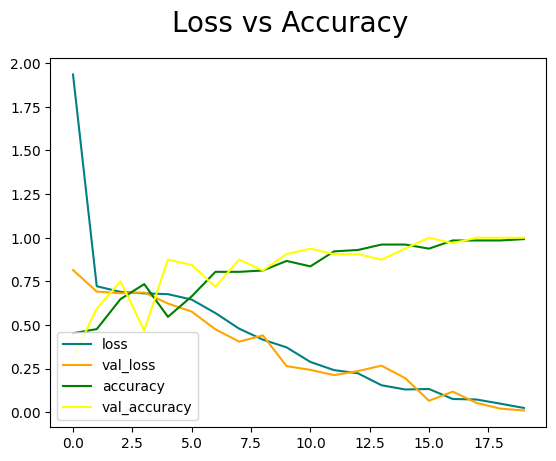

In [414]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='yellow', label='val_accuracy')
fig.suptitle('Loss vs Accuracy', fontsize=20)
plt.legend(loc="lower left")
plt.show()

Evaluate Performance

In [415]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [416]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [417]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 89ms/step


In [418]:
print(f'Precision:{pre.result()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy: 1.0


Test

In [419]:
import cv2

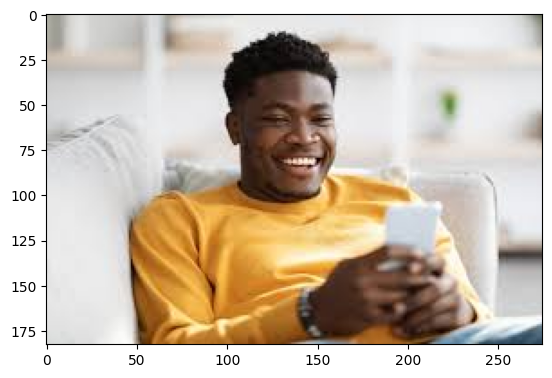

In [426]:
img = cv2.imread('happytest7.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

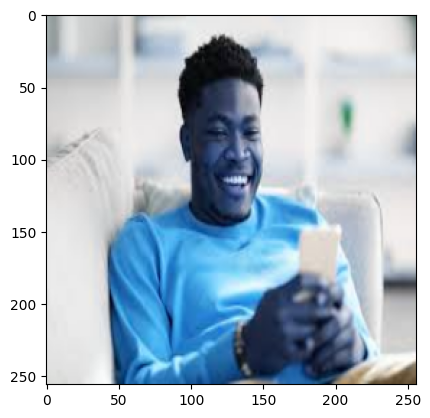

In [427]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [428]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 17ms/step


In [429]:
yhat

array([[0.5950884]], dtype=float32)

In [430]:
if yhat > 0.5:
    print(f'The photo is sad')
else:
    print(f'The photo is happy')

The photo is sad
